# Slate Star Codex Reader Survey 2018

If you enjoy this, let's connect on LinkedIn:

https://www.linkedin.com/in/vincefavilla/

I'm a psychology professor and machine learning engineer. Also, I'm in the SF Bay Area and looking for a job outside of academia. :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
sns.set_context('poster')

from warnings import filterwarnings
filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Politics

Disclaimer: I'm pretty liberal, but I tried my best not to inject my opinions here and let the data speak for itself!

In [2]:
data = pd.read_csv('ssc2018public_cleaned.csv')

In [3]:
def three_pt_scale(col):
    scale = np.zeros_like(data)
    scale = np.where(data[col] > 3, 'Favorable', np.nan)
    scale = np.where(data[col] == 3, 'Neutral', scale)
    scale = np.where(data[col] < 3, 'Unfavorable', scale)
    return pd.Series(scale[scale != 'nan'])

trump = three_pt_scale('DonaldTrump')
bernie = three_pt_scale('BernieSanders')

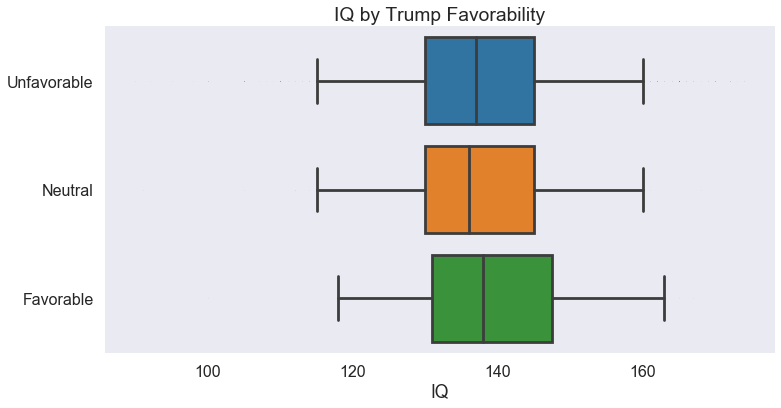

In [4]:
plt.figure(figsize=(12,6))

sns.boxplot(data['IQ'], trump, whis=1, orient='h', fliersize=.2)
plt.title('IQ by Trump Favorability')

In [6]:
from scipy.stats import ttest_ind

data['TrumpFavorability'] = trump

data_iq = data[data.IQ.notnull()]
ttest_ind(data_iq[data_iq.TrumpFavorability == 'Favorable']['IQ'],
         data_iq[data_iq.TrumpFavorability == 'Unfavorable']['IQ'])

Ttest_indResult(statistic=1.8488017188320107, pvalue=0.064651806991960006)

In [7]:
data['BernieFavorability'] = bernie

data_iq = data[data.IQ.notnull()]
ttest_ind(data_iq[data_iq.BernieFavorability == 'Favorable']['IQ'],
         data_iq[data_iq.BernieFavorability == 'Unfavorable']['IQ'])

Ttest_indResult(statistic=1.3684855618753464, pvalue=0.17138143510670215)

SSC Trump supporters appear to be more intelligent, on average. Go figure.

Conversely, we can't predict an SSC reader's intelligence by their support for Bernie Sanders.

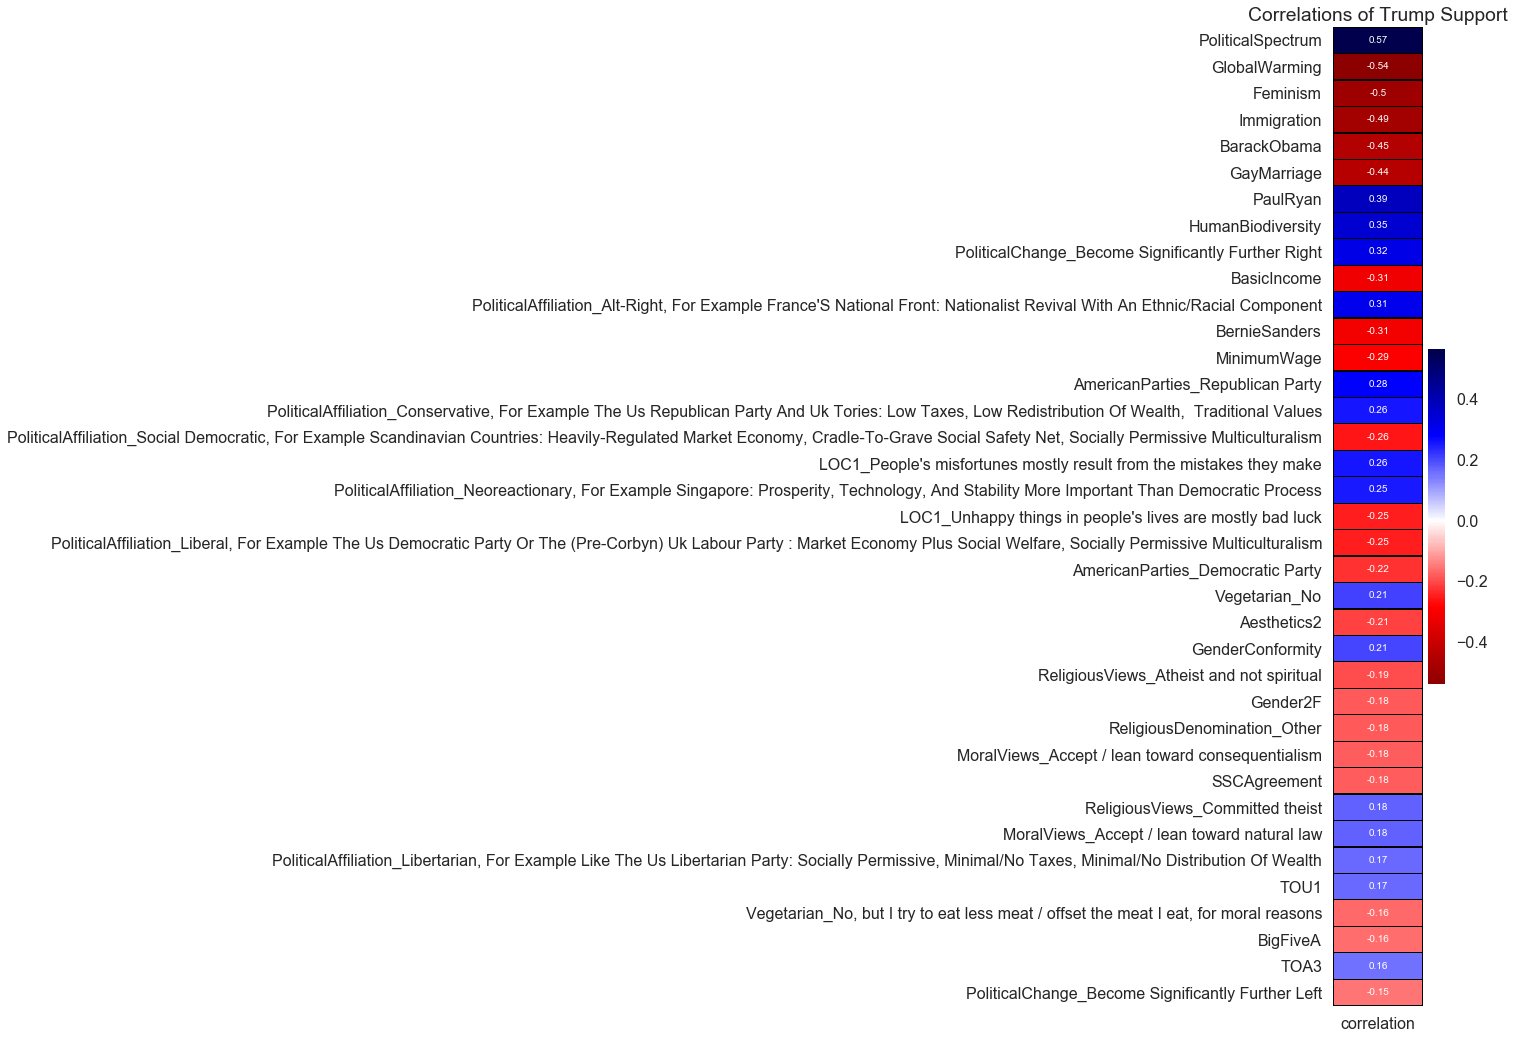

In [9]:
def absolute_correlations(col, df=data, ascending=False):
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    if ascending == False:
        return corrs.sort_values('absol', ascending=ascending).drop('absol', axis=1).tail(len(corrs)-1)
    else:
        return corrs.sort_values('absol', ascending=ascending).drop('absol', axis=1).head(len(corrs)-1)

def corrmap(df, cutoff=0.2, title='Correlations'):
    top_corrs = df[abs(df.correlation) > cutoff]
    plt.figure(figsize=(2,len(top_corrs)//2))
    plt.title(title)
    sns.heatmap(top_corrs, annot=True, fmt='.2g', cmap='seismic_r',
                center=0, linecolor='black', linewidths=.25)

# Correlations of Trump Support
tr = absolute_correlations('DonaldTrump', ascending=False)
corrmap(tr, cutoff=.15, title='Correlations of Trump Support')

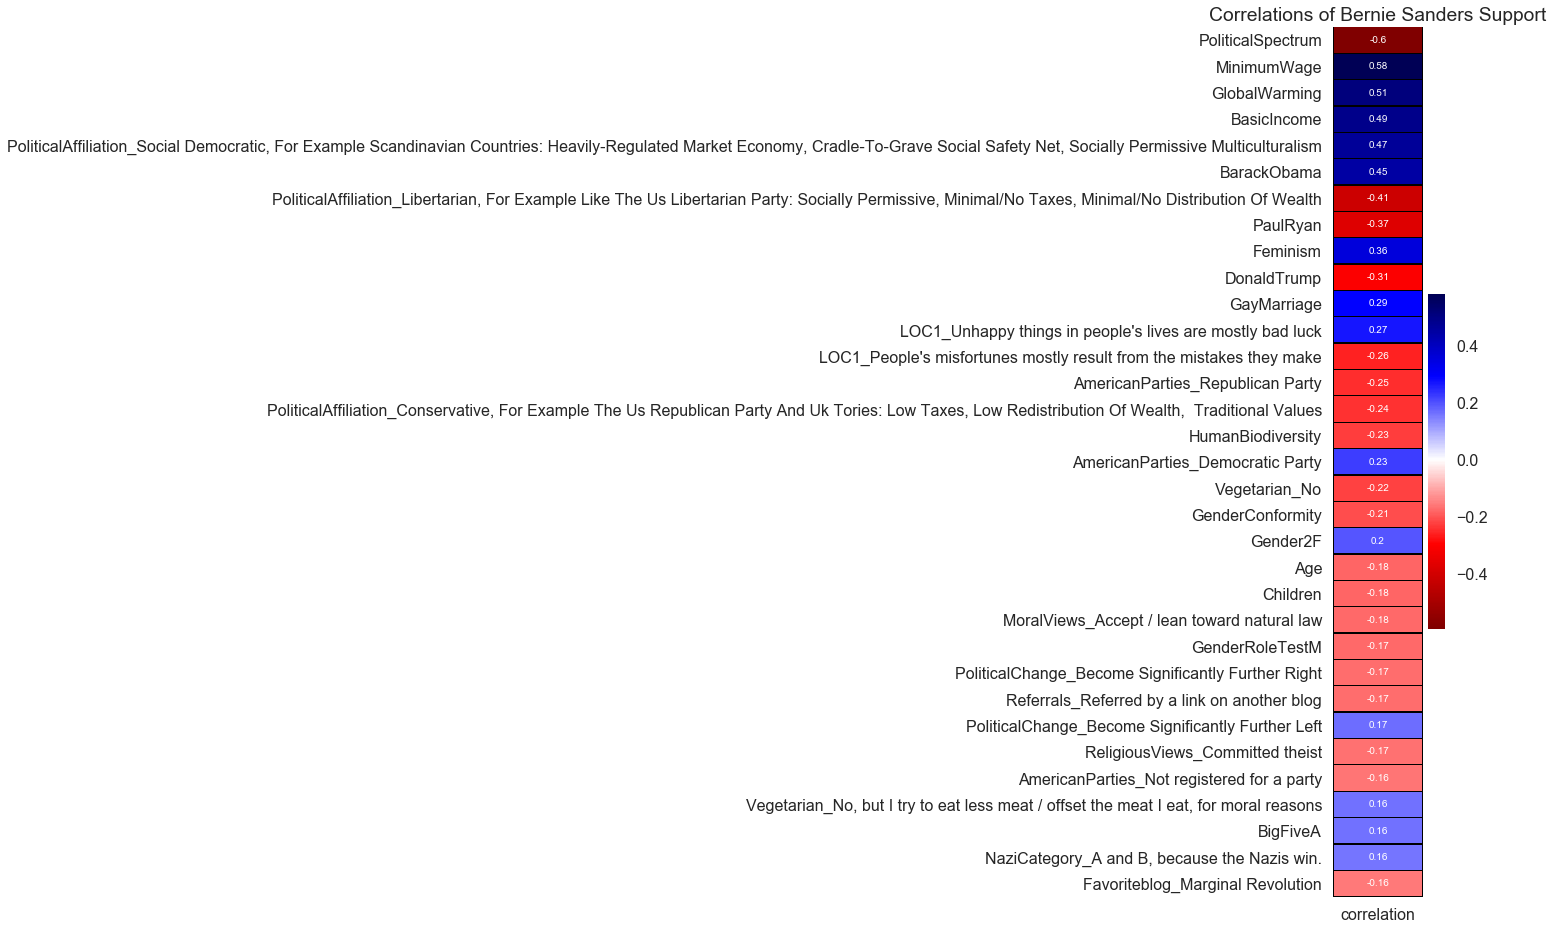

In [10]:
# Correlations of Bernie Sanders Support
bern = absolute_correlations('BernieSanders', ascending=False)
corrmap(bern, cutoff=.15, title='Correlations of Bernie Sanders Support')

So, are Trump supporters really more intelligent? This would be surprising. Openness to experience predicts IQ, and it's also correlated with liberal political beliefs.

Let's try something different. Let's try to infer IQ based *not* on what someone reports, but how they answer questions (particularly riddles) that correlate with IQ.

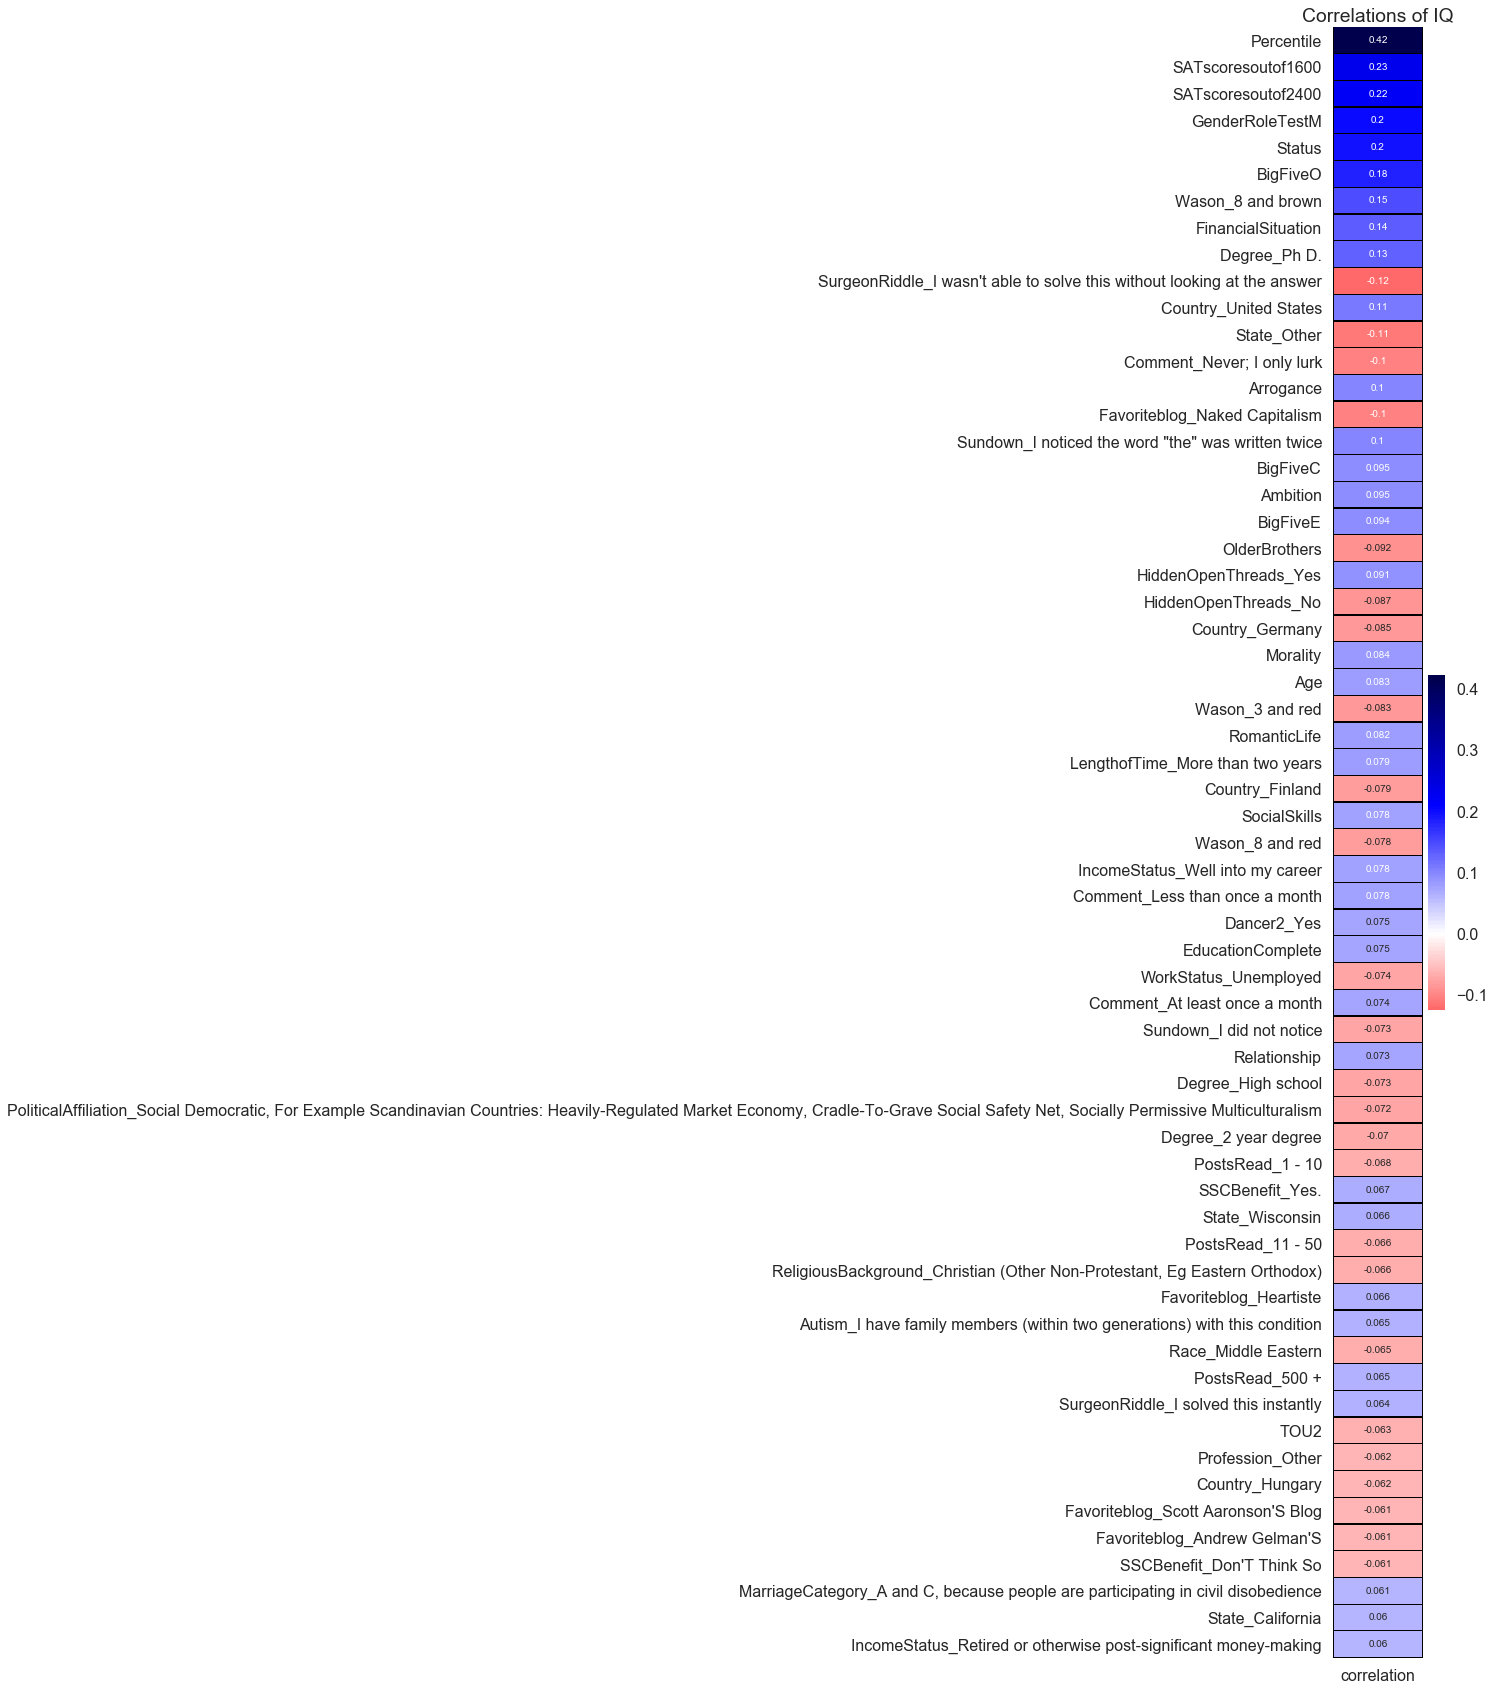

In [11]:
iq = absolute_correlations('IQ', ascending=False)
corrmap(iq, cutoff=.06, title='Correlations of IQ')

I chose to define "hidden IQ" with the following features. It can still be faked, but it's a little harder to do so.

In [12]:
data['HiddenIQ'] = (data['BigFiveO']/100 + data['Wason_8 and brown'] +
                  (1 - data['SurgeonRiddle_I wasn\'t able to solve this without looking at the answer']) +
                  data['SATscoresoutof1600'].fillna(data['SATscoresoutof1600'].mean()))/1600

(Fun fact: Removing openness from this actually *strengthens* the following correlations. You wouldn't expect that.)

In [13]:
from scipy import stats

t_iq = stats.pearsonr(data['HiddenIQ'].fillna(data['HiddenIQ'].median()),
               data['DonaldTrump'].fillna(data['DonaldTrump'].median()))

print('Donald Trump and IQ')
print('Correlation:\t', t_iq[0])
print('p-value:\t', t_iq[1])

Donald Trump and IQ
Correlation:	 -0.036498154289
p-value:	 0.00186866330269


In [14]:
b_iq = stats.pearsonr(data['HiddenIQ'].fillna(data['HiddenIQ'].median()),
               data['BernieSanders'].fillna(data['BernieSanders'].median()))

print('Bernie Sanders and IQ')
print('Correlation:\t', b_iq[0])
print('p-value:\t', b_iq[1])

Bernie Sanders and IQ
Correlation:	 0.028350621418
p-value:	 0.0157048981753


The p-values are significant, but the correlations are tiny. It's probably most accurate to call it a wash. Everyone on SSC is smart, regardless of political beliefs!

### Politics and Personality

Liberals tend to score higher in openness, while conservatives tend to score higher in conscientiousness. Let's see if the data backs this up.

In [15]:
print('Average openness to experience')
print(data.groupby('TrumpFavorability').mean()['BigFiveO'], '\n')

ttest_ind(data[data['TrumpFavorability'] == 'Favorable']['BigFiveO'].dropna(),
          data[data['TrumpFavorability'] == 'Unfavorable']['BigFiveO'].dropna())

Average openness to experience
TrumpFavorability
Favorable      71.079710
Neutral        72.501287
Unfavorable    72.342519
Name: BigFiveO, dtype: float64 



Ttest_indResult(statistic=-0.89632673271108887, pvalue=0.37013373479558742)

In [16]:
print('Average openness to experience')
print(data.groupby('BernieFavorability').mean()['BigFiveO'], '\n')

ttest_ind(data[data['BernieFavorability'] == 'Favorable']['BigFiveO'].dropna(),
          data[data['BernieFavorability'] == 'Unfavorable']['BigFiveO'].dropna())

Average openness to experience
BernieFavorability
Favorable      73.168516
Neutral        71.550705
Unfavorable    71.949489
Name: BigFiveO, dtype: float64 



Ttest_indResult(statistic=1.4850951540208013, pvalue=0.13762358015112591)

In [17]:
# Bernie vs. Trump in Openness
ttest_ind(data[data['BernieFavorability'] == 'Favorable']['BigFiveO'].dropna(),
          data[data['TrumpFavorability'] == 'Favorable']['BigFiveO'].dropna())

Ttest_indResult(statistic=1.4376893422357155, pvalue=0.15068585473682411)

It appears that openness doesn't play a strong role in political preferences on SSC. This is contrary to a lot of research on personality and politics!

Let's see what the deal is with conscientiousness. 

In [18]:
print('Average conscientiousness')
print(data.groupby('TrumpFavorability').mean()['BigFiveC'], '\n')

ttest_ind(data[data['TrumpFavorability'] == 'Favorable']['BigFiveC'].dropna(),
          data[data['TrumpFavorability'] == 'Unfavorable']['BigFiveC'].dropna())

Average conscientiousness
TrumpFavorability
Favorable      38.854545
Neutral        43.318896
Unfavorable    41.770849
Name: BigFiveC, dtype: float64 



Ttest_indResult(statistic=-1.650366167448198, pvalue=0.098948816492769778)

Now *this* is already interesting. It appears that conscientious readers, who are cautious and deliberate, are probably less likely to hold a favorable opinion of Trump. How about Bernie Sanders?

In [19]:
print('Average conscientiousness')
print(data.groupby('BernieFavorability').mean()['BigFiveC'], '\n')

ttest_ind(data[data['BernieFavorability'] == 'Favorable']['BigFiveC'].dropna(),
          data[data['BernieFavorability'] == 'Unfavorable']['BigFiveC'].dropna())

Average conscientiousness
BernieFavorability
Favorable      42.265055
Neutral        40.995620
Unfavorable    41.637606
Name: BigFiveC, dtype: float64 



Ttest_indResult(statistic=0.60253696271195667, pvalue=0.54686227648696262)

No difference here.

In [20]:
# Bernie vs. Trump in Conscientiousness
ttest_ind(data[data['BernieFavorability'] == 'Favorable']['BigFiveC'].dropna(),
          data[data['TrumpFavorability'] == 'Favorable']['BigFiveC'].dropna())

Ttest_indResult(statistic=1.8460610162078999, pvalue=0.065037912248022106)

But Bernie supporters seem to score higher in conscientiousness. Again, this is contrary to the psychological research.

## Politics and Personality

In [21]:
# Converting politics back into a categorical variable
pols = data[[i for i in data.columns if "PoliticalAffiliation_" in i]].copy()
data['Politics_categorical'] = pols.idxmax(axis=1)

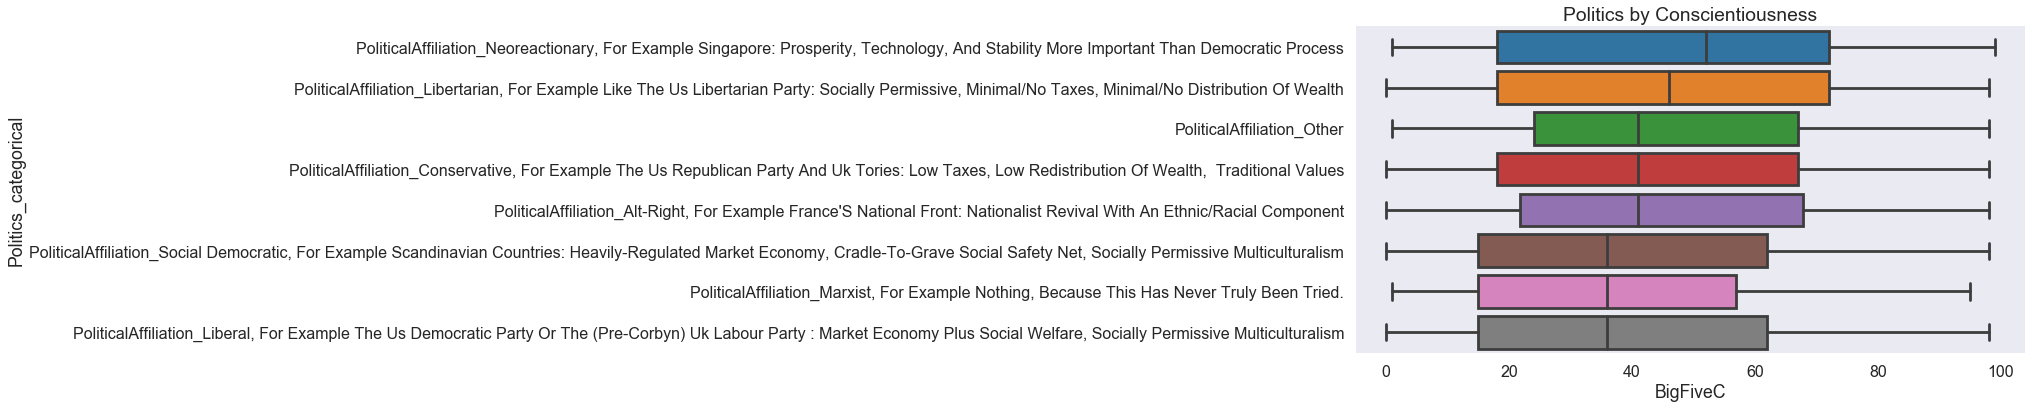

In [22]:
plt.figure(figsize=(12,6))

order = data.groupby('Politics_categorical').median()['BigFiveC'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveC'], data['Politics_categorical'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Politics by Conscientiousness')

In [24]:
def compare_top_and_bottom(col, order, top=0, bot=-1):
    df = data[data[col].notnull()]
    top_ix = order[top]
    bot_ix = order[bot]
    by = order.name
    
    if top == 0 and bot == -1:
        print('Highest ' + col + ': ' + top_ix)
        print('Lowest ' + col + ': ' + bot_ix)
    else:
        print('Comparing {} and {}'.format(top_ix, bot_ix))
    
    ttest = ttest_ind(df[df[by] == top_ix][col],
                      df[df[by] == bot_ix][col])
    return ttest

compare_top_and_bottom('BigFiveC', order)

Highest BigFiveC: PoliticalAffiliation_Neoreactionary, For Example Singapore: Prosperity, Technology, And Stability More Important Than Democratic Process
Lowest BigFiveC: PoliticalAffiliation_Liberal, For Example The Us Democratic Party Or The (Pre-Corbyn) Uk Labour Party : Market Economy Plus Social Welfare, Socially Permissive Multiculturalism


Ttest_indResult(statistic=2.9186521550841213, pvalue=0.0035695194139819123)

Big difference here. No surprise.

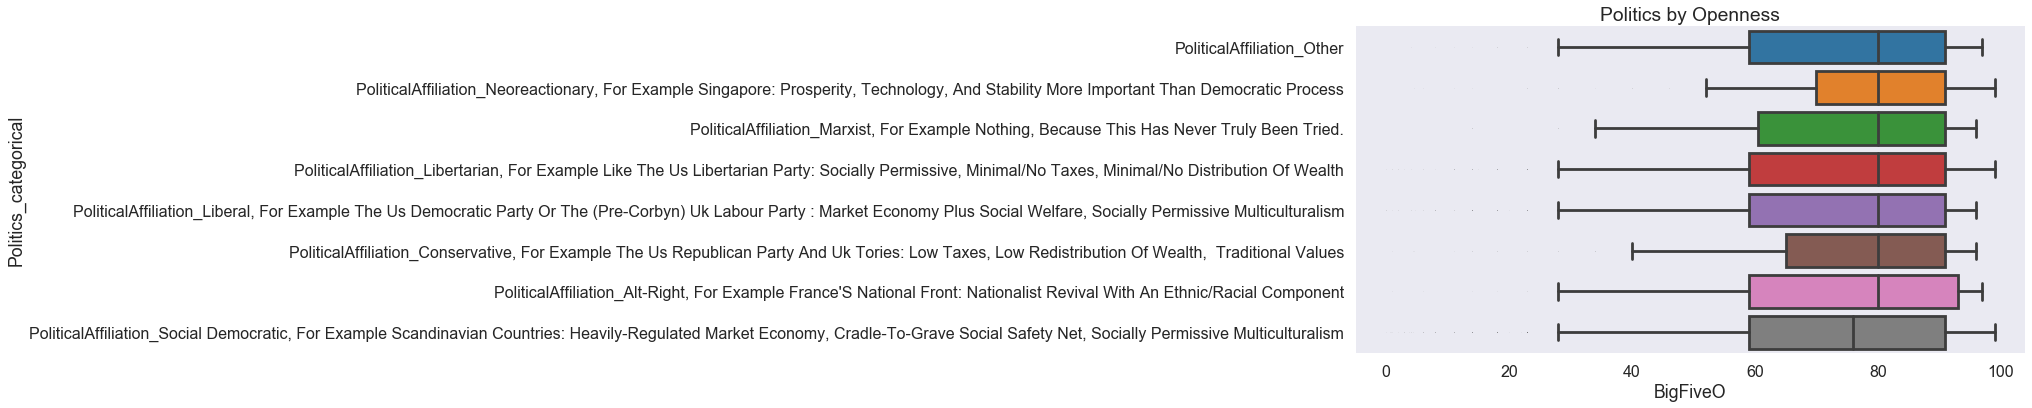

In [25]:
plt.figure(figsize=(12,6))

order = data.groupby('Politics_categorical').median()['BigFiveO'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveO'], data['Politics_categorical'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Politics by Openness')

In [26]:
compare_top_and_bottom('BigFiveO', order)

Highest BigFiveO: PoliticalAffiliation_Other
Lowest BigFiveO: PoliticalAffiliation_Social Democratic, For Example Scandinavian Countries: Heavily-Regulated Market Economy, Cradle-To-Grave Social Safety Net, Socially Permissive Multiculturalism


Ttest_indResult(statistic=0.87816855266868743, pvalue=0.37999004633290978)

No meaningful difference here. Recall that openness predicts political liberalism, so we should have seen liberals up top and conservatives at the bottom.

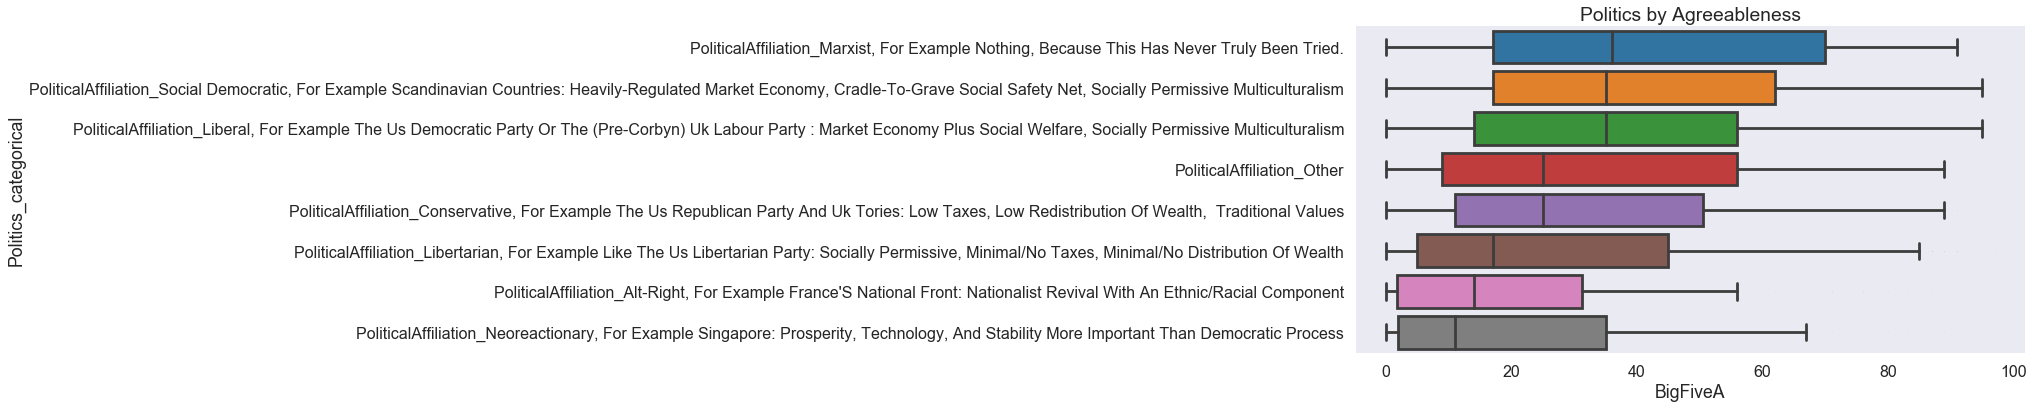

In [27]:
#
# PAY ATTENTION
# THIS ONE IS IMPORTANT!
#
#

plt.figure(figsize=(12,6))

order = data.groupby('Politics_categorical').median()['BigFiveA'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveA'], data['Politics_categorical'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Politics by Agreeableness')

In [28]:
compare_top_and_bottom('BigFiveA', order)

Highest BigFiveA: PoliticalAffiliation_Marxist, For Example Nothing, Because This Has Never Truly Been Tried.
Lowest BigFiveA: PoliticalAffiliation_Neoreactionary, For Example Singapore: Prosperity, Technology, And Stability More Important Than Democratic Process


Ttest_indResult(statistic=6.2957892552318464, pvalue=1.2101935891028188e-09)

### Agreeableness turns out to be the most intuitive predictor of political preference. As you might expect, liberals tend to be more agreeable than conservatives. Worth noting, however, is that this isn't true for the general population (liberals tend to be more compassionate, while conservatives tend to be more polite).

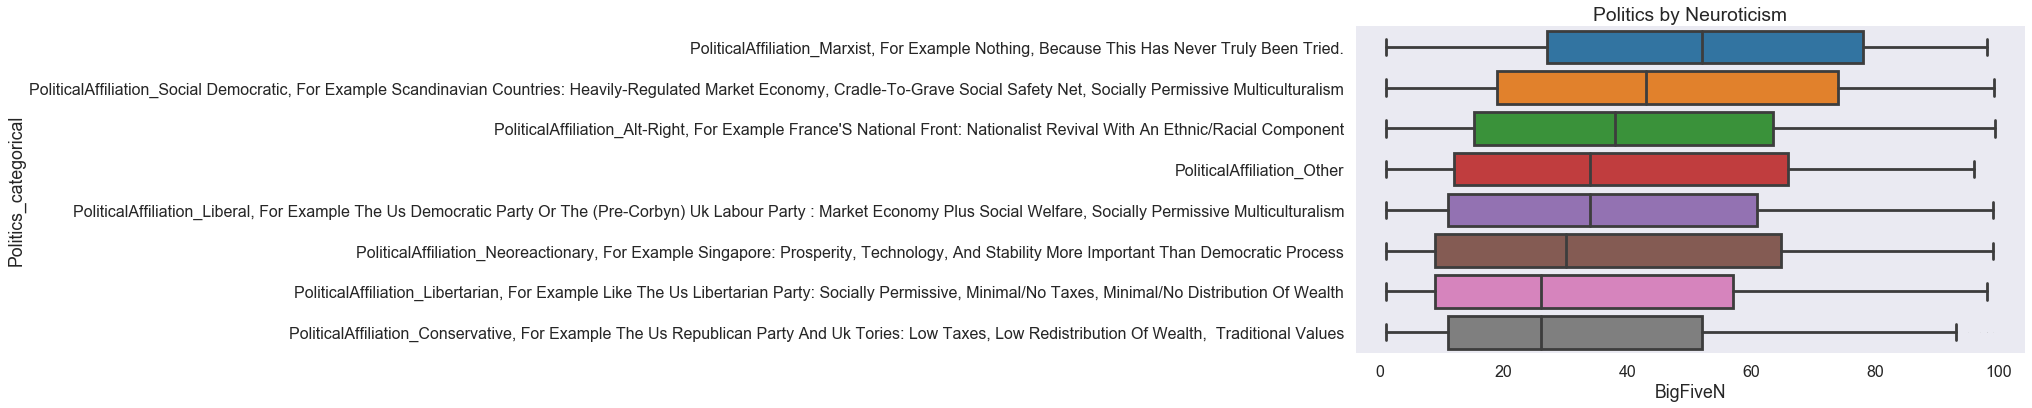

In [29]:
plt.figure(figsize=(12,6))

order = data.groupby('Politics_categorical').median()['BigFiveN'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveN'], data['Politics_categorical'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Politics by Neuroticism')

In [30]:
# Comparing Marxists and liberals, because that's more interesting
compare_top_and_bottom('BigFiveN', order, top=0, bot=4)

Comparing PoliticalAffiliation_Marxist, For Example Nothing, Because This Has Never Truly Been Tried. and PoliticalAffiliation_Liberal, For Example The Us Democratic Party Or The (Pre-Corbyn) Uk Labour Party : Market Economy Plus Social Welfare, Socially Permissive Multiculturalism


Ttest_indResult(statistic=3.6474188666269041, pvalue=0.00027496135859835641)

So, you could argue that people with poorer mental health find Marxism more appealing. Not too surprising ("from each according to their ability").

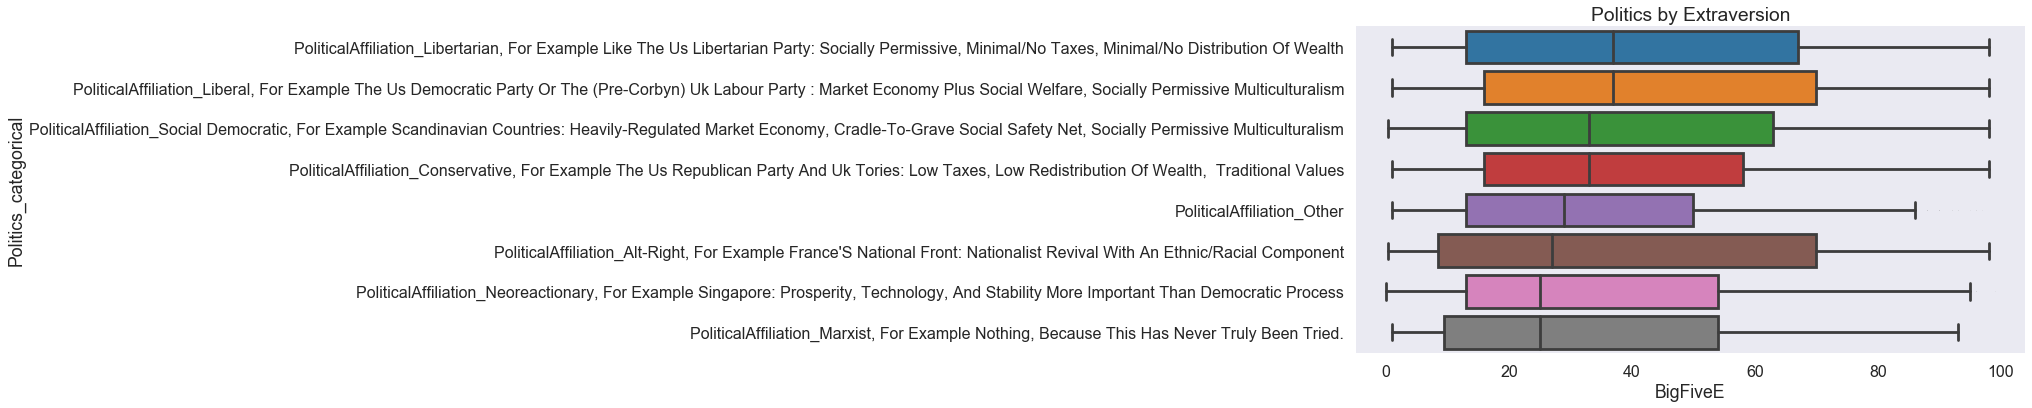

In [31]:
plt.figure(figsize=(12,6))

order = data.groupby('Politics_categorical').median()['BigFiveE'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveE'], data['Politics_categorical'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Politics by Extraversion')

In [32]:
compare_top_and_bottom('BigFiveE', order)

Highest BigFiveE: PoliticalAffiliation_Libertarian, For Example Like The Us Libertarian Party: Socially Permissive, Minimal/No Taxes, Minimal/No Distribution Of Wealth
Lowest BigFiveE: PoliticalAffiliation_Marxist, For Example Nothing, Because This Has Never Truly Been Tried.


Ttest_indResult(statistic=2.5000005274594503, pvalue=0.012577439616052694)

Every group is introverted on average, but libertarians are the least introverted.

# Factor analysis

There's a lot of this data that's the exact opposite of what I've seen in the past -- in particular when we look at the big five personality traits. There's a certain amount of homogeneity, especially when we look at traits like openness to experience or agreeableness. So let's look at how we can most meaningfully measure the differences in SSC readers.

In [72]:
# Going to use the inferred dataset again
data = pd.read_csv('ssc2018public_inferred.csv')
data = data[[i for i in data.columns if 'Favorite' not in i and 'State' not in i and 'Country' not in i]]

# We don't want these in our factor analysis
del data['Unnamed: 0']
del data['Timestamp']

data.shape

(7260, 505)

Isolation forest is a method of identifying outliers. We don't want the weirdos to influence the analysis too much, so we'll remove the 10% of responses that are most different from the others.

In [73]:
from sklearn.ensemble import IsolationForest

# Identify 10% as outliers
iso = IsolationForest(contamination=.10).fit(data)

inliers = iso.predict(data)
data = data[inliers == 1]

data.shape

(6534, 505)

In [74]:
# Min-max scaling rescales every value to 0 -> 1. (Going to be useful in a moment.)
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
datamms = pd.DataFrame(mms.fit_transform(data), columns=data.columns)

In [75]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=4).fit(datamms)

dfa = fa.transform(datamms)

factors = pd.DataFrame(fa.components_, columns=data.columns).T
factors_abs = abs(factors)
factors_abs.columns = ['absol_'+str(i) for i in factors.columns]
factors = pd.concat([factors,factors_abs], axis=1)

### Factor 1

Factor 1 measures conservatism.

In [76]:
f1 = factors.sort_values('absol_0', ascending=False)[[0]]
f1.columns = ['loading']
f1[abs(f1) > .1].dropna()

,loading
"PoliticalAffiliation_Social Democratic, For Example Scandinavian Countries: Heavily-Regulated Market Economy, Cradle-To-Grave Social Safety Net, Socially Permissive Multiculturalism",-0.212275
LOC1_Unhappy things in people's lives are mostly bad luck,-0.206026
LOC1_People's misfortunes mostly result from the mistakes they make,0.205174
GlobalWarming,-0.195465
BernieSanders,-0.183338
PoliticalSpectrum,0.177095
Feminism,-0.175273
"PoliticalAffiliation_Libertarian, For Example Like The Us Libertarian Party: Socially Permissive, Minimal/No Taxes, Minimal/No Distribution Of Wealth",0.172873
Vegetarian_No,0.170723
MinimumWage,-0.169846


### Factor 2

This factor appears to measure mental health and relationship satisfaction.

In [77]:
f2 = factors.sort_values('absol_1', ascending=False)[[1]]
f2.columns = ['loading']
f2[abs(f2) > .1].dropna()

,loading
Relationship,-0.183673
RomanticLife,-0.159647
LifeSatisfaction,-0.137185
TOU4,0.116492
SocialSkills,-0.114492
MoodScale,-0.113198
ChangeOverTenYears,-0.110773
Status,-0.103798
BigFiveN,0.100377
Autism_I don't have this condition and neither does anyone in my family,-0.100041


### Factor 3

Factor 3 appears to measure intelligence and locus of control. (You'd probably agree with me that these two shouldn't necessarily be combined.)

In [78]:
f3 = factors.sort_values('absol_2', ascending=False)[[2]]
f3.columns = ['loading']
f3[abs(f3) > .1].dropna()

,loading
PreviousSurveys_Yes,-0.212829
Wason_8 and brown,-0.200878
LOC3_What happens to me is mostly my own doing,-0.187744
Dancer2_No,-0.181757
Navon2_Shape A,-0.176318
"LOC2_When I make plans, I mostly expect that I can make them work",-0.175226
CRTM_Yes,-0.159760
Mask1_Yes,-0.159621
Navon1_E,-0.159500
LengthofTime_More than two years,-0.157016


No meaningful factors were identified after this one. The loadings are already pretty small.

## Factor Analysis: Method 2

If those results aren't satisfying, I've developed another method. I don't know if there's a name for it, but here's essentially what I'll do:

1. Find the most "controversial" questions on the survey. These are the ones whose responses have the highest standard deviation.

2. Find items that correlate with those controversial questions. If we identify 4 or more, we can call it a "factor."

3. From the remaining the questions, find those that correlate **least** with the factor we just found.

4. Find items that correlate with this new, orthogonal question. Create a new factor with that question.

5. Continue this process until we can no longer find questions uncorrelated with those we've already analyzed.

Honestly, this is a pretty neat method. I'd be pretty surprised if I invented it!

In [79]:
# Transpose the dataframe, so we're analyzing questions instead of users
qs = datamms.T

qs['stdev'] = qs.std(axis=1)

questions_sorted = qs.sort_values('stdev', ascending=False)['stdev'].index

# Most controversial at top; least controversial at bottom
# This is why we had to re-scale all the questions earlier.
questions_sorted

Index(['PreviousSurveys_Yes',
       'Dancer_I could make the the dancer change directions',
       'PatreonI_No, don't want to',
       'Tables_The one on the left is about 25% longer',
       'HiddenOpenThreads_Yes', 'PoliticalChangeSSC_No Significant Change',
       'Discord_No, I didn't know it existed',
       'LOC1_Unhappy things in people's lives are mostly bad luck',
       'PoliticalDisagreementI_They Seem Pretty Wrong, But They Make Understandable Mistakes And Are Probably Mostly Decent People',
       'HiddenOpenThreads_No',
       ...
       'ReligiousBackground_Baha'I', 'SSCBenefit_Don'T Know',
       'SSCChangeMind_Effective Altruism', 'SSCBenefit_No?', 'SSCBenefit_Nah',
       'ReligiousBackground_Atheism', 'Charity',
       'ReligiousDenomination_Polytheist', 'Gender2M', 'CRT2'],
      dtype='object', length=505)

In [80]:
def absolute_correlations(col, df=data, threshold=.5):
    '''Finds related questions, with both positive and negative correlations'''
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs[corrs.absol > threshold].sort_values('absol', ascending=False).drop('absol', axis=1)

In [81]:
from collections import defaultdict

# Record which questions go in each factor
factors = defaultdict(list)

# Use each question only once
questions_used = []

# Put users' scores in a dataframe
df_factors = pd.DataFrame()

for question in questions_sorted:
    if question not in questions_used:
        related = absolute_correlations(
            question,
            df=datamms[[i for i in datamms.columns if i not in questions_used]],
            threshold=.50
        )        
        if len(related) >= 4:
            for related_question in related.index:
                questions_used.append(related_question)
            factors[question].append(related.index)
            
            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)   

            df_factors[question] = (datamms[pos_items].sum(axis=1) + (1-datamms[neg_items]).sum(axis=1))/(len(all_items))
            
print('found', str(df_factors.shape[1]), 'personality traits')

found 5 personality traits


In [82]:
from collections import defaultdict

# Record which questions go in each factor
factors = defaultdict(list)

# We're no longer going to worry if a question has been used
# We're now more interested in validity and reliability than style!
questions_used = []

# Put users' scores in a dataframe
df_factors = pd.DataFrame()

th = 0.50
lenrel = 4

# Seed the dataframe with the first reliable trait
for question in questions_sorted:
    related = absolute_correlations(
        question,
        df=datamms,
        threshold=th
    )        
    if len(related) >= lenrel:
        factors[question].append(related.index)

        pos_items = related[related['correlation'] > 0].index
        neg_items = related[related['correlation'] < 0].index
        all_items = list(pos_items) + list(neg_items)   

        df_factors[question] = (datamms[pos_items].sum(axis=1) + (1-datamms[neg_items]).sum(axis=1))/(len(all_items))
        break

df_factors.head()

,ReligiousDenomination_Other
0,0.75
1,1.00
2,0.75
3,1.00
4,0.00


In [83]:
corr = 0
corr_th = .5

# Run this until we find a trait that correlates more than corr_th with an existing one
while corr < corr_th:
    next_q = datamms.corrwith(df_factors[df_factors.columns[-1]])
    candidates = pd.DataFrame()
    for i in np.abs(next_q).sort_values().index:
        related = absolute_correlations(
            i,
            df=data,
            threshold=th)        
        if len(related) >= lenrel:

            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)
            candidates[i] = (datamms[pos_items].sum(axis=1) + (1-datamms[neg_items]).sum(axis=1))/(len(all_items))

    candidates_scores = {}
    for i in candidates.columns:
        candidates_scores[i] = np.abs(df_factors.corrwith(candidates[i])).max()

    candidates_scores = pd.DataFrame([candidates_scores]).T.sort_values(0)  
    corr = candidates_scores.get_value(candidates_scores.index[0], 0)
    if corr > corr_th:
        break
    print('Using:', pd.DataFrame(candidates_scores).index[0])
    print(round(corr, 2))
    
    next_q = datamms.corrwith(df_factors[df_factors.columns[-1]])
    candidates = pd.DataFrame()
    for i in candidates_scores.index:
        related = absolute_correlations(
            i,
            df=data, threshold=th)        
        if len(related) >= lenrel:
            factors[i].append(related.index)

            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)
            df_factors[i] = (datamms[pos_items].sum(axis=1) + (1-datamms[neg_items]).sum(axis=1))/(len(all_items))    
            break
    if i == candidates_scores.index[-1]:
        raise Exception('Could not find any more traits')
    
    print()

Using: Mask3_Like it's facing towards you, so that the tip of its nose is closest to you
0.02

Using: SSCChangeMind_Other
0.03

Using: Gender_F (cisgender)
0.05

Using: MinimumWage
0.17



In [84]:
factors

defaultdict(list,
            {'Gender_F (cisgender)': [Index(['Gender_F (cisgender)', 'Sex_Female', 'Sex_Male',
                     'Gender_M (cisgender)'],
                    dtype='object')],
             "Mask3_Like it's facing towards you, so that the tip of its nose is closest to you": [Index(['Mask3_Like it's facing towards you, so that the tip of its nose is closest to you',
                     'Mask1_Yes', 'Mask3_Unsure/could be either', 'Dancer2_No'],
                    dtype='object')],
             'MinimumWage': [Index(['MinimumWage', 'BernieSanders', 'PoliticalSpectrum',
                     'PoliticalAffiliation_Libertarian, For Example Like The Us Libertarian Party: Socially Permissive, Minimal/No Taxes, Minimal/No Distribution Of Wealth'],
                    dtype='object')],
             'ReligiousDenomination_Other': [Index(['ReligiousDenomination_Other',
                     'ReligiousDenomination_Christian (Protestant)',
                     'ReligiousViews_Co

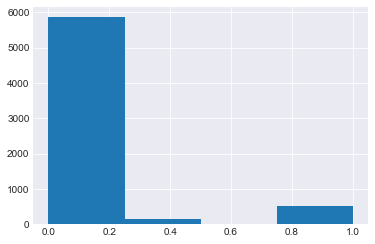

In [90]:
df_factors['Gender_F (cisgender)'].hist(bins=4)

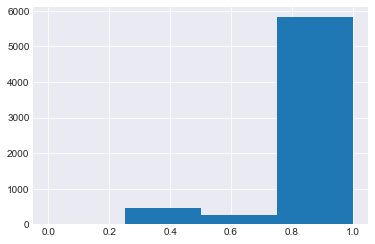

In [91]:
df_factors['Mask3_Like it\'s facing towards you, so that the tip of its nose is closest to you'].hist(bins=4)

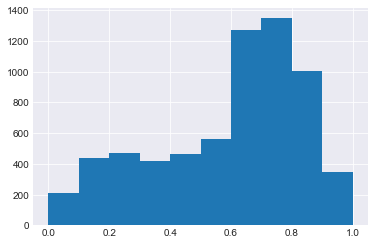

In [92]:
df_factors['MinimumWage'].hist()

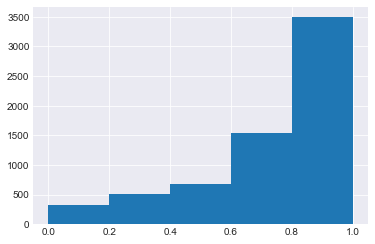

In [93]:
df_factors['ReligiousDenomination_Other'].hist(bins=5)

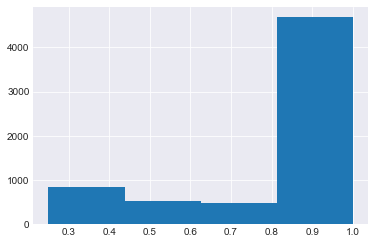

In [94]:
df_factors["SSCChangeMind_Other"].hist(bins=4)

In [107]:
data = pd.read_csv('ssc2018public_inferred.csv')

from scipy.stats import pearsonr
blogs = []
for i in data[[i for i in data.columns if 'Favoriteblog' in i and 'Other' not in i]].columns:
    corr = pearsonr(data['PoliticalSpectrum'], data[i])
    blogs.append([i.replace('Favoriteblog_', ''), corr[0], corr[1]])
    
blogs = pd.DataFrame(blogs, columns=['blog', 'corr', 'pvalue'])

In [109]:
blogs[blogs.pvalue < .01].sort_values('corr').head(20)

,blog,corr,pvalue
188,Thing Of Things,-0.060040,3.063239e-07
160,Shtetl-Optimized,-0.049275,2.665447e-05
114,Naked Capitalism,-0.048444,3.636659e-05
22,Blog.Fefe.De,-0.045844,9.323384e-05
79,Kevin Drum,-0.037916,1.232486e-03
199,Waitbutwhy,-0.034218,3.546701e-03
180,The Unit Of Caring,-0.032293,5.926318e-03
187,Theunitofcaring.Tumblr.Com,-0.030875,8.515097e-03
36,David Friedman,0.031055,8.138314e-03
203,Westhunter,0.031055,8.138314e-03


In [110]:
blogs[blogs.pvalue < .01].sort_values('corr', ascending=False).head(20)

,blog,corr,pvalue
167,Steve Sailer,0.119585,1.543442e-24
75,Instapundit,0.101820,3.415327e-18
92,Marginal Revolution,0.101663,3.845116e-18
195,Unqualified Reservations,0.094142,9.138697e-16
40,Econlog,0.086565,1.486086e-13
197,Vox Popoli,0.066625,1.330088e-08
78,Isteve,0.053837,4.436876e-06
27,Chateau Heartiste,0.048573,3.466458e-05
89,Lion Of The Blogosphere,0.048332,3.790586e-05
207,Xenosystems,0.048190,3.995143e-05


In [111]:
np.corrcoef(data['Gender_F (transgender m -> f)'], data['Mask1_Yes'])

array([[ 1.        , -0.02543965],
       [-0.02543965,  1.        ]])

In [112]:
np.corrcoef(data['Gender_M (transgender f -> m)'], data['Mask1_Yes'])

array([[ 1.       , -0.0061252],
       [-0.0061252,  1.       ]])

In [113]:
np.corrcoef(data['Gender_F (transgender m -> f)'], data['Mask2_Yes'])

array([[ 1.        , -0.02914461],
       [-0.02914461,  1.        ]])

In [114]:
np.corrcoef(data['Gender_M (transgender f -> m)'], data['Mask2_Yes'])

array([[ 1.       , -0.0047996],
       [-0.0047996,  1.       ]])